<a href="https://colab.research.google.com/github/Anonymousundefined/ML/blob/main/ecg_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import datetime
import os
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import signal
from scipy.signal import medfilt
import pywt
from pywt import wavedec

In [ ]:
DATASET_DIR = '../input/shaoxing-and-ningbo-first-hospital-database/WFDB_ShaoxingUniv'
print('DATASET DIR ::',DATASET_DIR)

# >------ global variables  ------------------------------------------
g_DATA = '.mat'
g_HEAD = '.hea'
g_leads = ['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6' ]
BASIC_SRATE = 500 #Hz
print('Basic sampling rate(Hz):',BASIC_SRATE)

DATASET DIR :: ../input/shaoxing-and-ningbo-first-hospital-database/WFDB_ShaoxingUniv
Basic sampling rate(Hz): 500


In [ ]:
rec_list = os.listdir(DATASET_DIR)
rec_count = 0
rec_count_expected = int(len(rec_list)/2)
rec_name_sep = ','
rec_file = open('RECORDS.csv','w')
rec_file.write(str(rec_count_expected))
for f in rec_list:
    if f.endswith(g_HEAD):
        rec_name = f[0:-4]
        rec_file.write(rec_name_sep+rec_name) #<---- use skiprows=1 in np.loadtxt()
        rec_count+=1
rec_file.close()
assert(rec_count_expected == rec_count) # should be equal )
print(rec_count)

FileNotFoundError: ignored

In [ ]:
fig,ax = plt.subplots(12,1, figsize=(20,12*4))
#fig.set_dpi(150)
for i in range(0,12):
    _key = g_leads[i]
    #ax[i].set_title(_key)
    ax[i].plot(ecg.signald[_key], color='black', linewidth=0.6)
    ax[i].set_ylim((-1500,1500))
    ax[i].set_xticks(   np.arange(0,5001,500)  )
    ax[i].set_xticklabels(   np.arange(0,5001,500)/BASIC_SRATE  )
    ax[i].grid(axis='x')
    ax[i].annotate(_key,(-200,0))
    #ax[i].set_xlabel('Time(sec)')
    #ax[i].set_ylabel('mV')
    ax[i].hlines(0,0,5000,color='black', linewidth=0.3)



In [ ]:
class ecg_segment:
    # represent a 10 sec signal of ecg from 12 leads

    def __init__(self, seg_name):
        self.name = seg_name
        self.file_mat = os.path.join(DATASET_DIR,self.name+'.mat')
        self.file_hea = os.path.join(DATASET_DIR,self.name+'.hea')
        self.load_data()
        self.load_header()


    def load_data(self):
        self.signals=loadmat(self.file_mat)['val'].astype(np.float64)
        self.signald = {}
        for i in range(0,len(g_leads)):
            self.signald[g_leads[i]] = self.signals[i,:]
        # an array of shape (12, 5000) each row is a lead in g_leads
        return

    def load_header(self):
        with open(self.file_hea,'r') as f:
            hlines=f.readlines() # each line ends with newline char
            #JS34506 12 500 5000 28-Mar-2021 04:58:01
            #0    (6x1) < from row0 extract everything
            tl = (hlines[0][0:-1]).split(" ")
            assert (tl[0] == self.name)
            assert (tl[1] == '12')
            assert (tl[2] == '500')
            assert (tl[3] == '5000')
            #self.timestamp = datetime.datetime.strptime("%d-%b-%Y_%H:%M:%S", tl[4]+'_'+tl[5])
            for i in range(1,12):
                assert ((hlines[i][0:-1]).split(" ")[8] == g_leads[i-1])
                assert ((hlines[i][0:-1]).split(" ")[8] == g_leads[i-1])

            self.age = int(hlines[13][0:-1].split(" ")[1])
            self.gender = hlines[14][0:-1].split(" ")[1]
            self.Dx = (hlines[15][0:-1].split(" ")[1])
            self.Rx = (hlines[16][0:-1].split(" ")[1])
            self.Hx = (hlines[17][0:-1].split(" ")[1])
            self.Sx = (hlines[18][0:-1].split(" ")[1])

        return

    def info(self):
        print(self.name,self.gender,self.age)
        return

ECG SIGNAL PREPROCESSING

In [ ]:
_lr,_lc = 3,4
_leads = [
    [['I'],['aVR'],['V1'],['V4']],
    [['II'],['aVL'],['V2'],['V5']],
    [['III'],['aVF'],['V3'],['V6']]
]


fig,ax = plt.subplots(_lr,_lc, figsize=(_lr*7,_lc*4))
#fig.set_dpi(150)
for i in range(0,3):
    for j in range(0,4):
        _key = _leads[i][j][0]
        ax[i,j].set_title(_key)
        ax[i,j].plot(ecg.signald[_key], color='black', linewidth=0.6)
        ax[i,j].set_ylim((-1500,1500))
        ax[i,j].set_xlim((0,5000))
        ax[i,j].hlines(0,0,5000,color='black',linestyle='dotted')
plt.show()

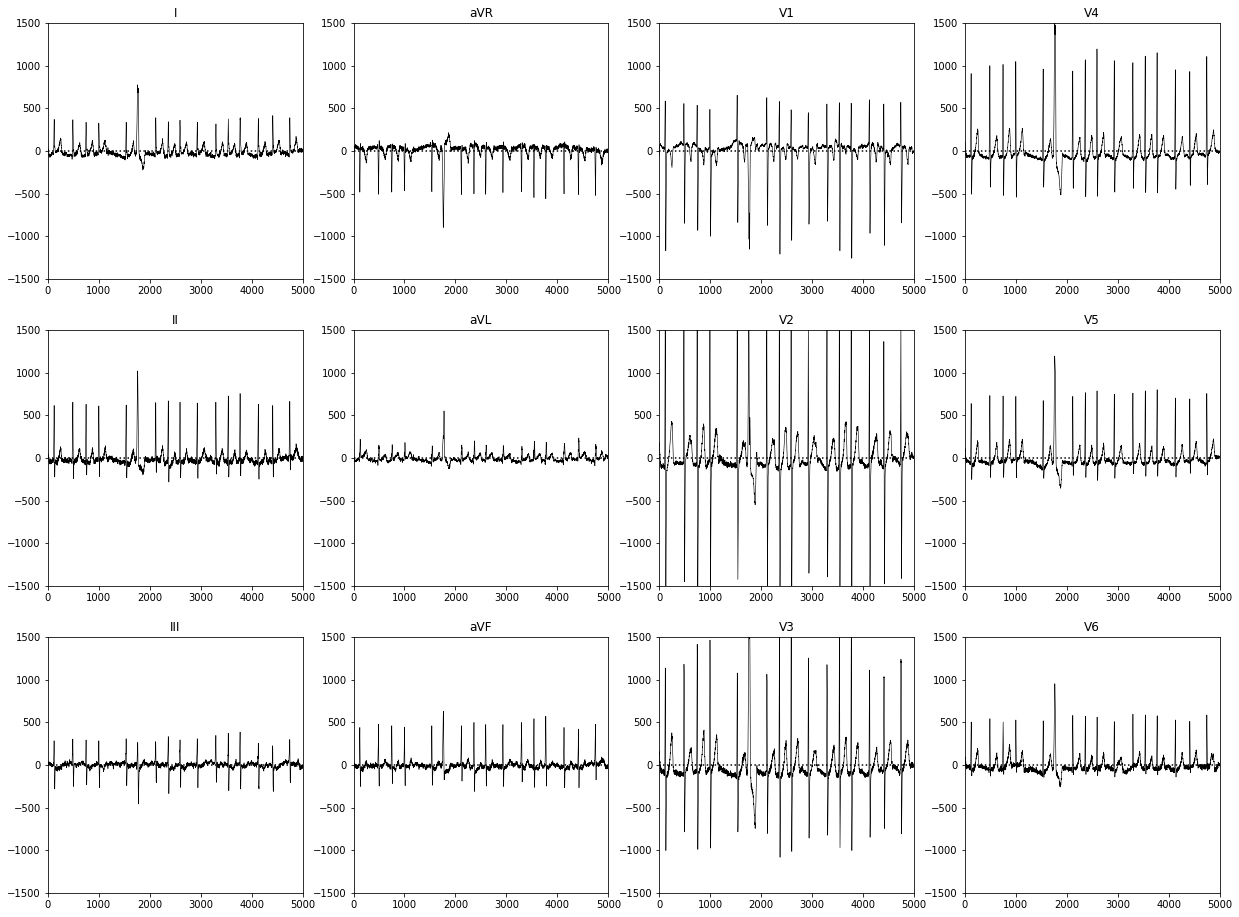

remove baseline **wander**

In [ ]:


def get_median_filter_width(sampling_rate, duration):
    res = int( sampling_rate*duration )
    res += ((res%2) - 1) # needs to be an odd number
    return res
# baseline fitting by filtering
# === Define Filtering Params for Baseline fitting Leads======================
ms_flt_array = [0.2,0.6]    #<-- length of baseline fitting filters (in seconds)
mfa = np.zeros(len(ms_flt_array), dtype='int')
for i in range(0, len(ms_flt_array)):
    mfa[i] = get_median_filter_width(BASIC_SRATE,ms_flt_array[i])

def filter_signal(X):
    global mfa
    X0 = X  #read orignal signal
    for mi in range(0,len(mfa)):
        X0 = medfilt(X0,mfa[mi]) # apply median filter one by one on top of each other
    X0 = np.subtract(X,X0)  # finally subtract from orignal signal
    return X0



signal_flt = filter_signal(signal_den)
plt.figure(figsize=(40,6))

plt.plot(signal_den, color='tab:purple', linewidth=0.6,label = 'input')
plt.plot(signal_flt, color='black', linewidth=0.9,label = 'filtered')
plt.hlines(0,0,5000,color='black', linewidth=0.4)
plt.legend()
plt.show()

plt.figure(figsize=(40,6))
plt.plot(signal_flt, color='black', linewidth=0.9,label = 'filtered')
plt.fill_between(np.arange(0,5000,1),signal_den,signal_flt,color='tab:pink',label = 'diff')
plt.hlines(0,0,5000,color='black', linewidth=0.4)
plt.legend()
plt.show()


r peak detection



In [ ]:
signal_pad_samples = 10
signal_pad = np.zeros(signal_pad_samples) # pad one sec to detect initial peaks properly
signalf = signal_flt
detectors = Detectors(BASIC_SRATE)

detectors = {
            'pan_tompkins_detector':[detectors.pan_tompkins_detector, []],
            'hamilton_detector':[detectors.hamilton_detector, []],
            'christov_detector':[detectors.christov_detector, []],
            'engzee_detector':[detectors.engzee_detector, []],
            'swt_detector':[detectors.swt_detector, []],
            'two_average_detector':[detectors.two_average_detector, []],
            }


for kd in detectors.keys():
    vd = detectors[kd]
    r_peaks = np.array(vd[0](np.hstack((signal_pad,signal_flt)))) - signal_pad_samples
    vd[1] = r_peaks
    plt.figure(figsize=(40,6))
    plt.title(kd)
    plt.plot(signalf,color='tab:blue',linewidth=0.8)
    plt.hlines(0,0,5000,color='black', linewidth=0.4)
    plt.xticks(r_peaks)
    plt.grid(axis='x')
    plt.show()
